# Variational AutoEncoder (derived from keras blog)

**Author:** Shahid Dhamani

**ML2 Learning LAB 2**

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import scipy.stats as st
import matplotlib.pyplot as plt

## Create a sampling layer


In [16]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Encoder


In [17]:
latent_dim = 2 #2 so we can draw them in a 2d space

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2d_3[0][0]                   
____________________________________________________________________________________________

## Decoder


In [18]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

#VAE as a `Model` with a custom `train_step` for losses


In [19]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


### Training VAE


In [20]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 5s 8ms/step - loss: 202.4932 - reconstruction_loss: 199.3933 - kl_loss: 3.0999
Epoch 2/30
547/547 [==============================] - 4s 8ms/step - loss: 164.4813 - reconstruction_loss: 160.8191 - kl_loss: 3.6622
Epoch 3/30
547/547 [==============================] - 4s 8ms/step - loss: 157.4777 - reconstruction_loss: 153.9194 - kl_loss: 3.5583
Epoch 4/30
547/547 [==============================] - 4s 8ms/step - loss: 154.3572 - reconstruction_loss: 150.7865 - kl_loss: 3.5707
Epoch 5/30
547/547 [==============================] - 4s 8ms/step - loss: 152.2883 - reconstruction_loss: 148.7012 - kl_loss: 3.5870
Epoch 6/30
547/547 [==============================] - 4s 8ms/step - loss: 150.9574 - reconstruction_loss: 147.3618 - kl_loss: 3.5956
Epoch 7/30
547/547 [==============================] - 4s 8ms/step - loss: 149.7027 - reconstruction_loss: 146.0847 - kl_loss: 3.6180
Epoch 8/30
547/547 [==============================] - 4s 8ms/step - l

In [21]:
mu, var, z = encoder.predict(x_test) # 2 for each mu, var, z because of latent shape

In [22]:
mu.shape

(10000, 2)

In [23]:
mu1 = mu[:, 0]

In [24]:
mu2 = mu[:, 1]

## Display how the latent space clusters different digit classes


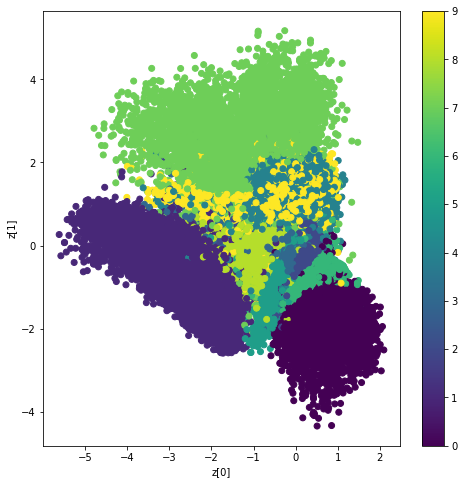

In [25]:
def plot_label_clusters(encoder, decoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(8, 8))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
plot_label_clusters(encoder, decoder, x_train, y_train)

## QUESTION 1 

Plotting a gaussian based on mean of latent vectors for the latent space

-674.5608459472656 544.5128112792969 -990.039453125 985.442529296875


Text(0.5, 0.92, 'Surface plot of Gaussian 2D KDE')

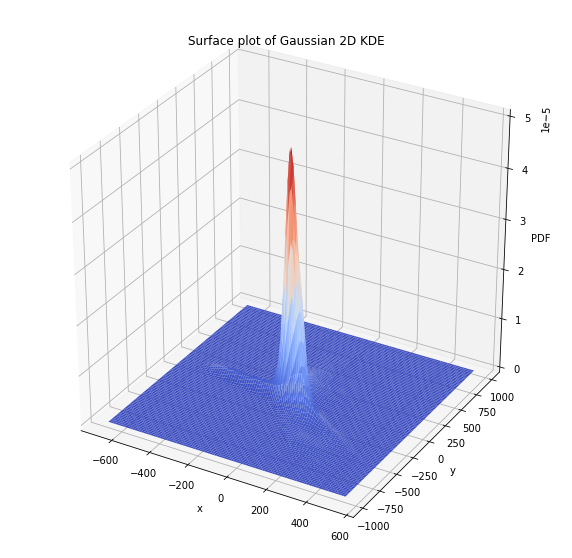

In [26]:
x = mu1
y = mu2
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY
print(xmin, xmax, ymin, ymax)

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx, yy, f, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Surface plot of Gaussian 2D KDE')

## Question 2

To see the effect of latent vectors we have varied them over the grid so we see how the variation of mean of latent vector effects the output

### Display a grid of sampled digits


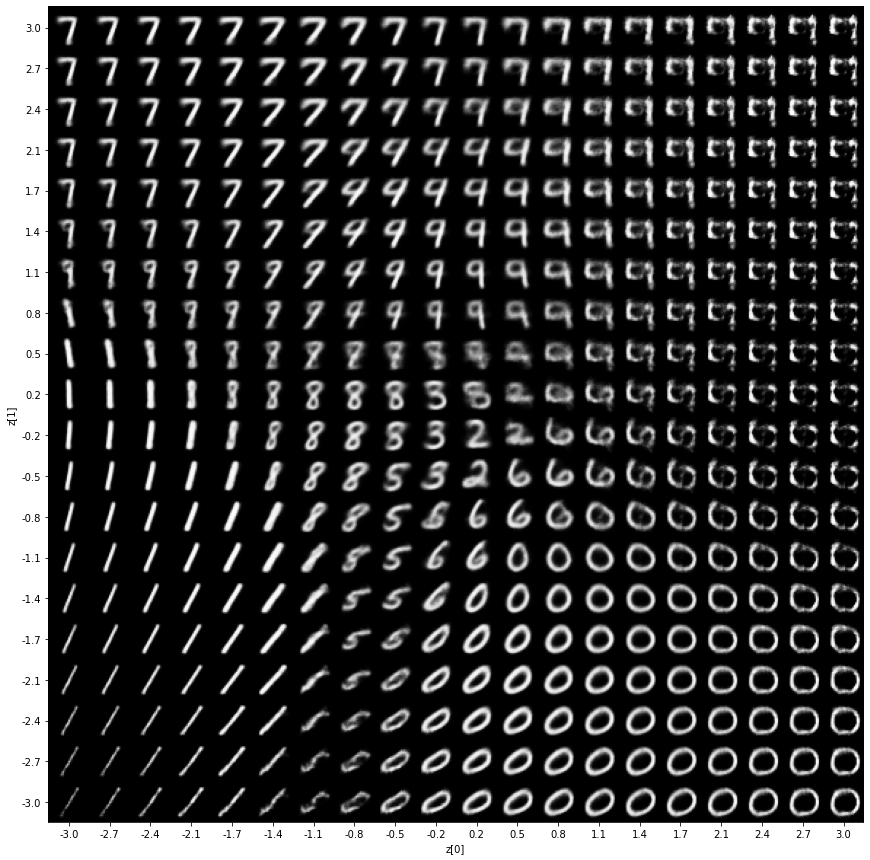

In [29]:

def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 20
    digit_size = 28
    scale = 3.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)


Here we can latent vectors at both ends - changing mean of first latent vector results in 

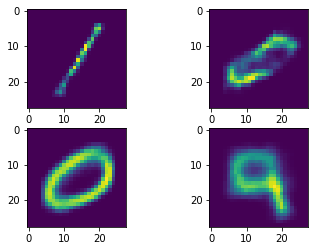

In [30]:
plt.subplot(221)
sample_vector = np.array([[-3,-3]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(28, 28)
plt.imshow(decoded_example_reshaped)
plt.subplot(222)
sample_vector = np.array([[-.8,-3]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(28, 28)
plt.imshow(decoded_example_reshaped)
plt.subplot(223)
sample_vector = np.array([[0.5,-3]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(28, 28)
plt.imshow(decoded_example_reshaped)
plt.subplot(224)
sample_vector = np.array([[0.5,.8]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(28, 28)
plt.imshow(decoded_example_reshaped)

As we can see the latent vectors effects the curvature with axis of rotation diagonal of the space both of which rotating + shearing the digit in opposite direction - z[0] in clockwise direction and z[1] in anticlockwise 